# Lecture 26 - Variational Inference

**DISCLAIMER** The material for this notebook is heavily based on PyMC3 variational inference tutorials by  Christopher Fonnesbeck (http://stronginference.com/pymc3-release.html).

In [8]:
import pandas as pd
import pymc as pm
import pymc3 as pm3
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from IPython.core.pylabtools import figsize
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

# Revisiting Polynomial Regression Problem (Using PyMC3 Variational Inference)

In [12]:
# We need a generic function that computes the design matrix
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in xrange(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

class PolynomialBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    degree  -  The degree of the polynomial.
    """
    def __init__(self, degree):
        self.degree = degree
        self.num_basis = degree + 1
    def __call__(self, x):
        return np.array([x[0] ** i for i in range(self.degree + 1)])
    

class FourierBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    num_terms  -  The number of Fourier terms.
    L          -  The period of the function.
    """
    def __init__(self, num_terms, L):
        self.num_terms = num_terms
        self.L = L
        self.num_basis = 2 * num_terms
    def __call__(self, x):
        res = np.ndarray((self.num_basis,))
        for i in xrange(num_terms):
            res[2 * i] = np.cos(2 * i * np.pi / self.L * x[0])
            res[2 * i + 1] = np.sin(2 * (i+1) * np.pi / self.L * x[0])
        return res
    

class RadialBasisFunctions(object):
    """
    A set of linear basis functions.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed lengthscale.
    """
    def __init__(self, X, ell):
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def __call__(self, x):
        return np.exp(-.5 * (x - self.X) ** 2 / self.ell ** 2).flatten()

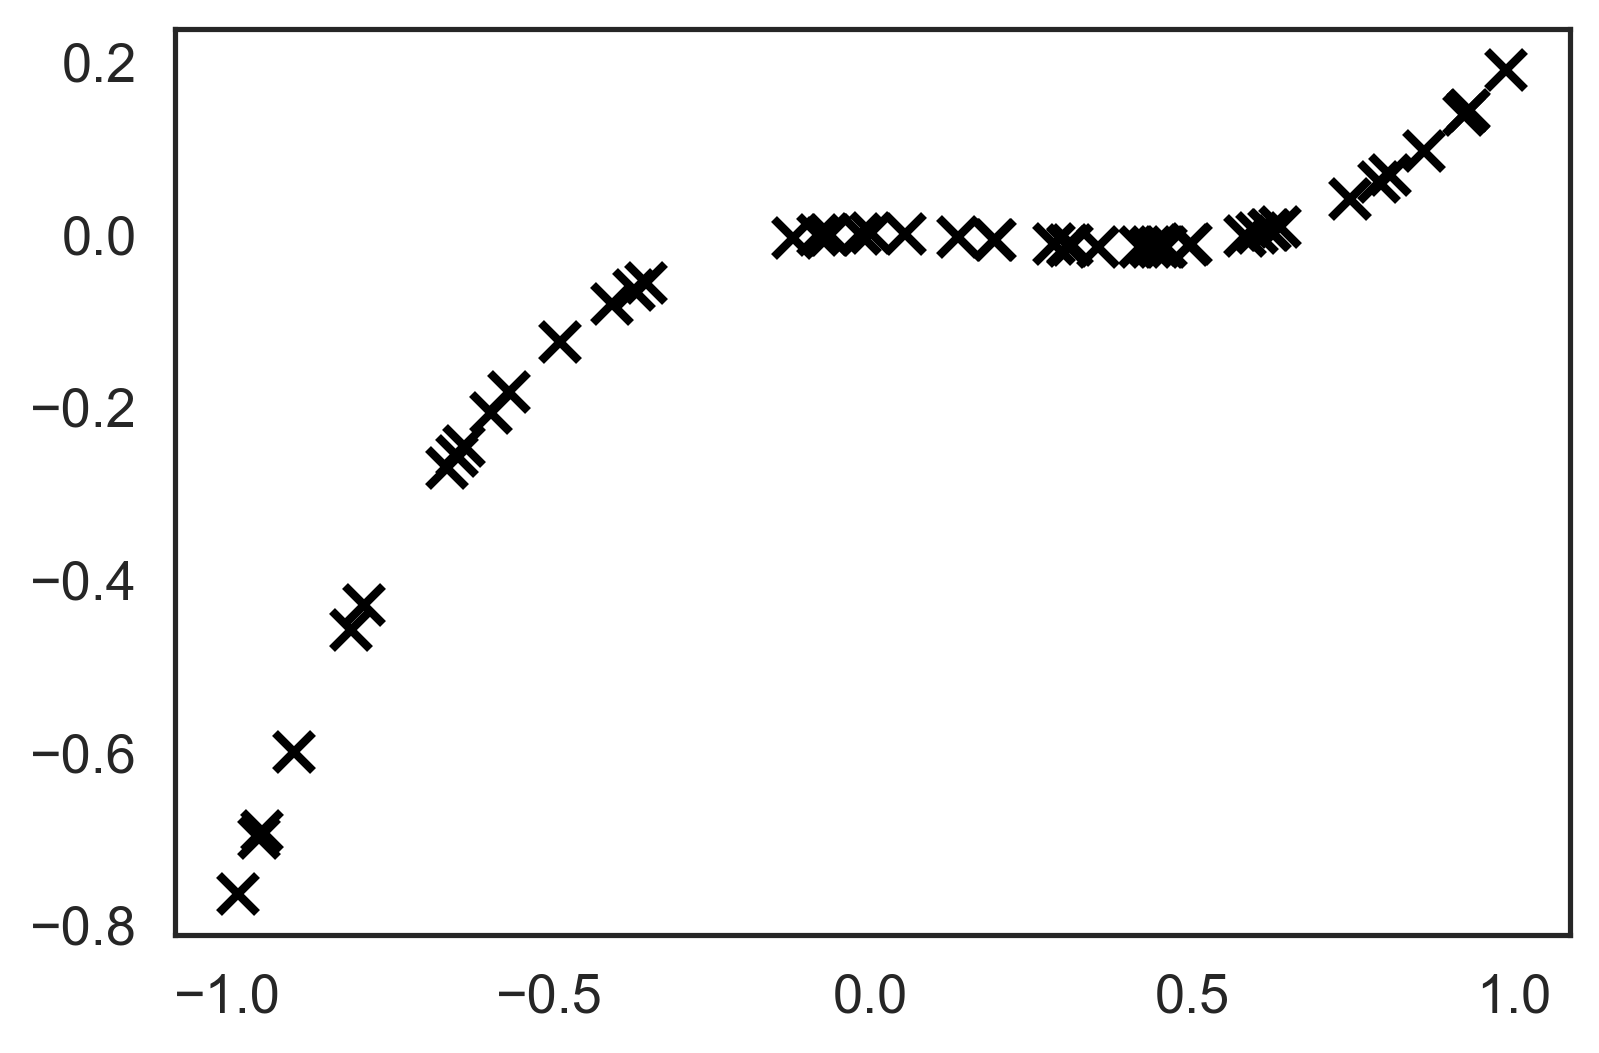

In [13]:
np.random.seed(12345)
num_samples = 50
sigma2 = 1e-6
X = 2 * np.random.rand(num_samples) - 1.
y = 0.5 * X  ** 3 - 0.3 * X ** 2 + np.sqrt(sigma2) * np.random.rand(num_samples)
plt.plot(X, y, 'kx', markeredgewidth=2)

In [14]:
def make_model_pm3(Phi, y):
    model = pm3.Model()
    with model:
        # The prior for sigma
        sigma2 = pm3.InverseGamma('sigma2', alpha = .5, beta = .5, testval = 0.1)
        # The prior for alpha
        alpha = pm3.InverseGamma('alpha', alpha = .5, beta = .5, testval = 0.1)
        # The prior of the weights
        w = pm3.Normal('w', mu = T.zeros(Phi.shape[1]), tau = alpha, shape = Phi.shape[1])
        # The likelihood
        y_obs = pm3.Normal('y_obs', mu = T.dot(Phi, w), tau = 1. / sigma2, observed = y)
      
        advi = pm3.ADVI()
    return advi

In [15]:
def fit_poly_pm3(phi, X, y):
    Phi = compute_design_matrix(X[:, None], phi)
    advi = make_model_pm3(Phi, y)
    advi.fit(n = 50000, obj_optimizer = pm3.adam())
    return advi

def plot_posteriors_pm3(advi):
    samples = advi.approx.sample(1000)
    W = samples['w']
    fig, ax = plt.subplots()
    for j in xrange(W.shape[1]):
        ax.hist(W[:, j], normed=True, alpha=0.5, label='$w_{%d}$' % j)
    plt.legend(loc='best')
    fig, ax = plt.subplots()
    alpha = samples['alpha']
    ax.hist(alpha, normed=True, label='$\alpha$', alpha=0.5)
    ax.set_xlabel('alpha')
    fig, ax = plt.subplots()
    sigma2 = samples['sigma2']
    ax.hist(sigma2, normed=True, label='$\sigma^2$', alpha=0.5)
    ax.set_xlabel('sigma2')
    
def plot_predictive_pm3(phi, advi, num_samples=100):
    Xt = np.linspace(-1, 1, 100)
    Phit = compute_design_matrix(Xt[:, None], phi)
    samples = advi.approx.sample(1000)
    W = samples['w']
    sigma2 = samples['sigma2']
    # We find the percantiles numerically
    Ys = np.ndarray((num_samples * 1000, Phit.shape[0]))
    for i in xrange(W.shape[0]):
        w = W[i, :]
        sigma = np.sqrt(sigma2[i])
        Yt = np.dot(Phit, w)
        for j in xrange(num_samples):
            Ys[i * num_samples + j, :] = Yt + sigma * np.random.randn(*Yt.shape)
    Ym = np.percentile(Ys, 50, axis=0)
    Yu = np.percentile(Ys, 97.5, axis=0)
    Yl = np.percentile(Ys, 2.5, axis=0)
    fig, ax = plt.subplots()
    ax.plot(Xt, Ym, color=sns.color_palette()[0])
    ax.fill_between(Xt, Yl, Yu, color=sns.color_palette()[0], alpha=0.25)
    ax.plot(X, y, 'kx', markeredgewidth=2)

Average Loss = -15.431: 100%|██████████| 50000/50000 [00:53<00:00, 938.84it/s] 
Finished [100%]: Average Loss = -15.434


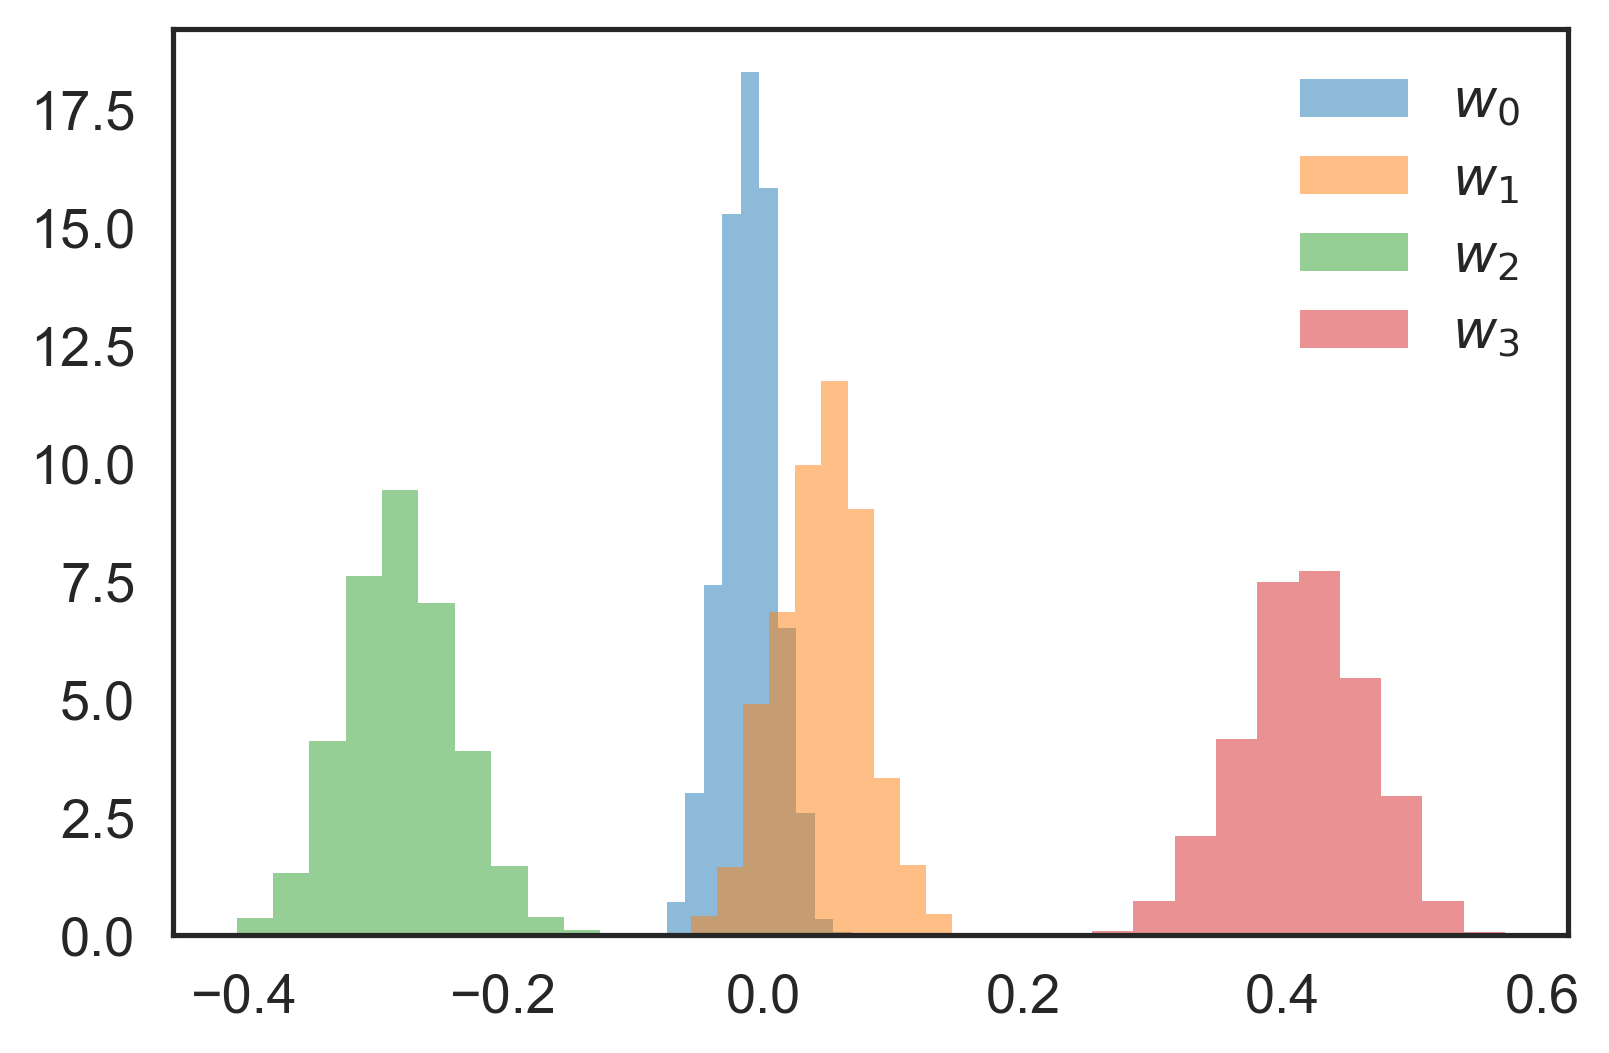

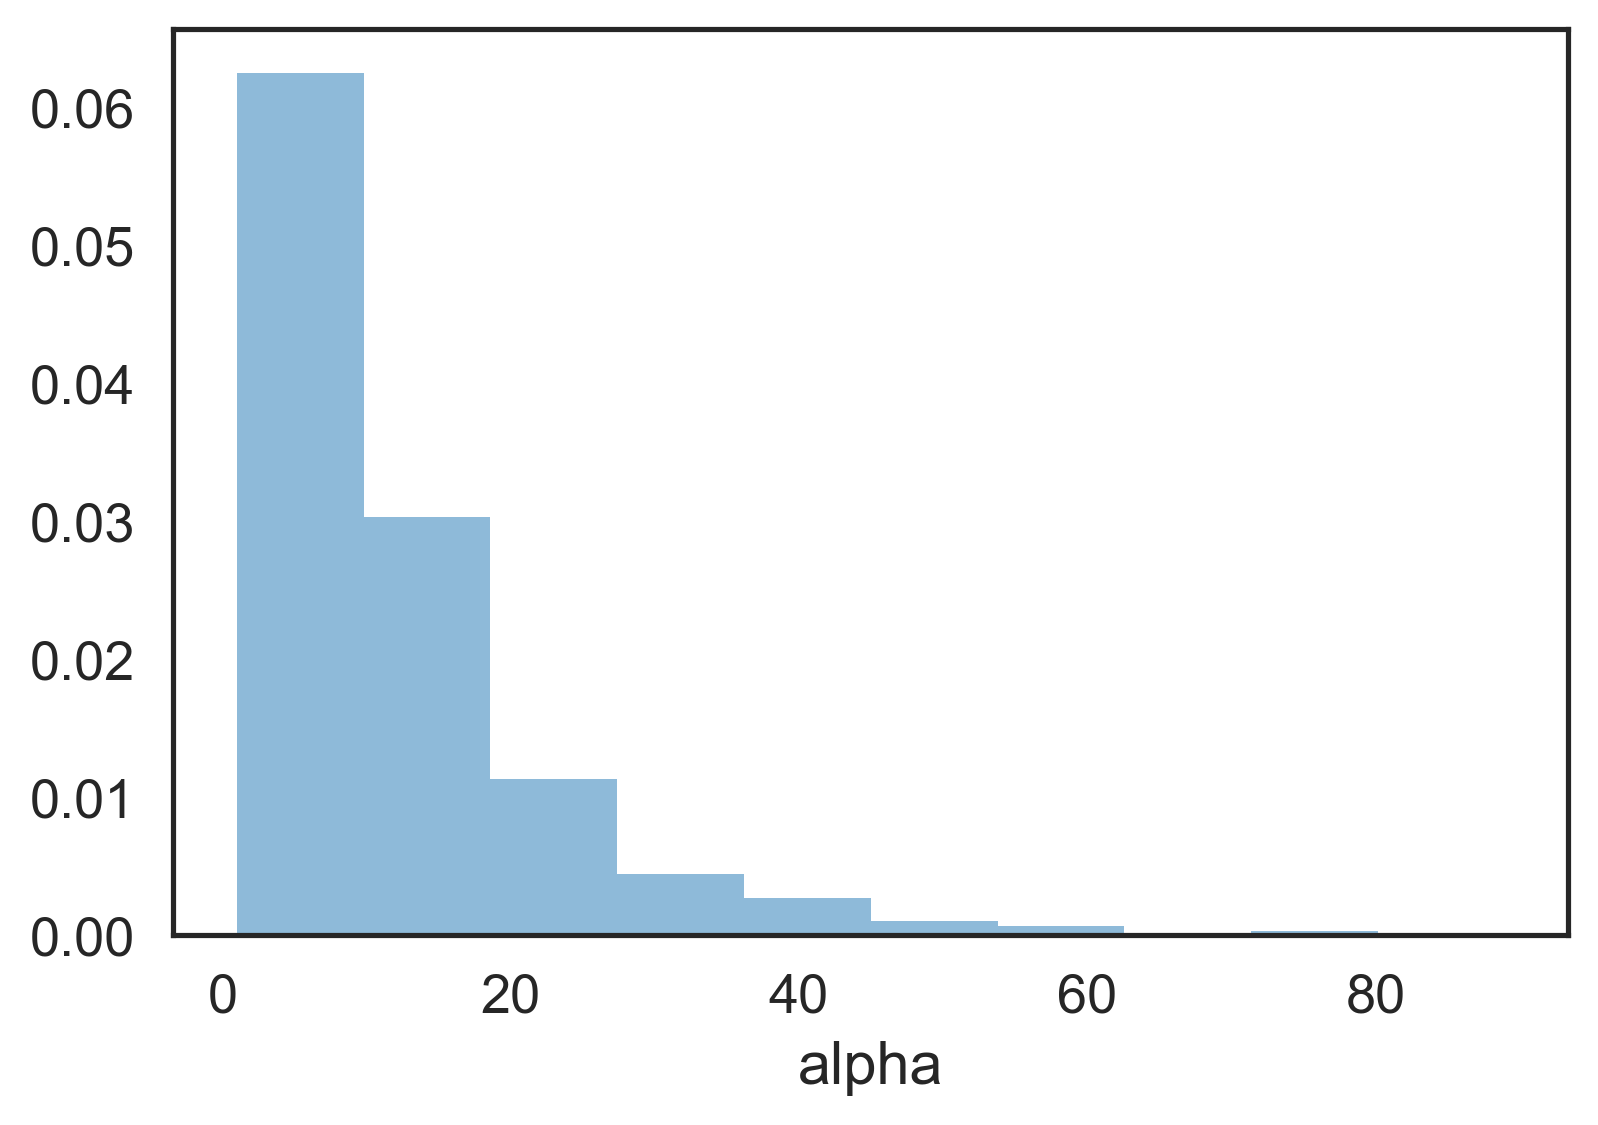

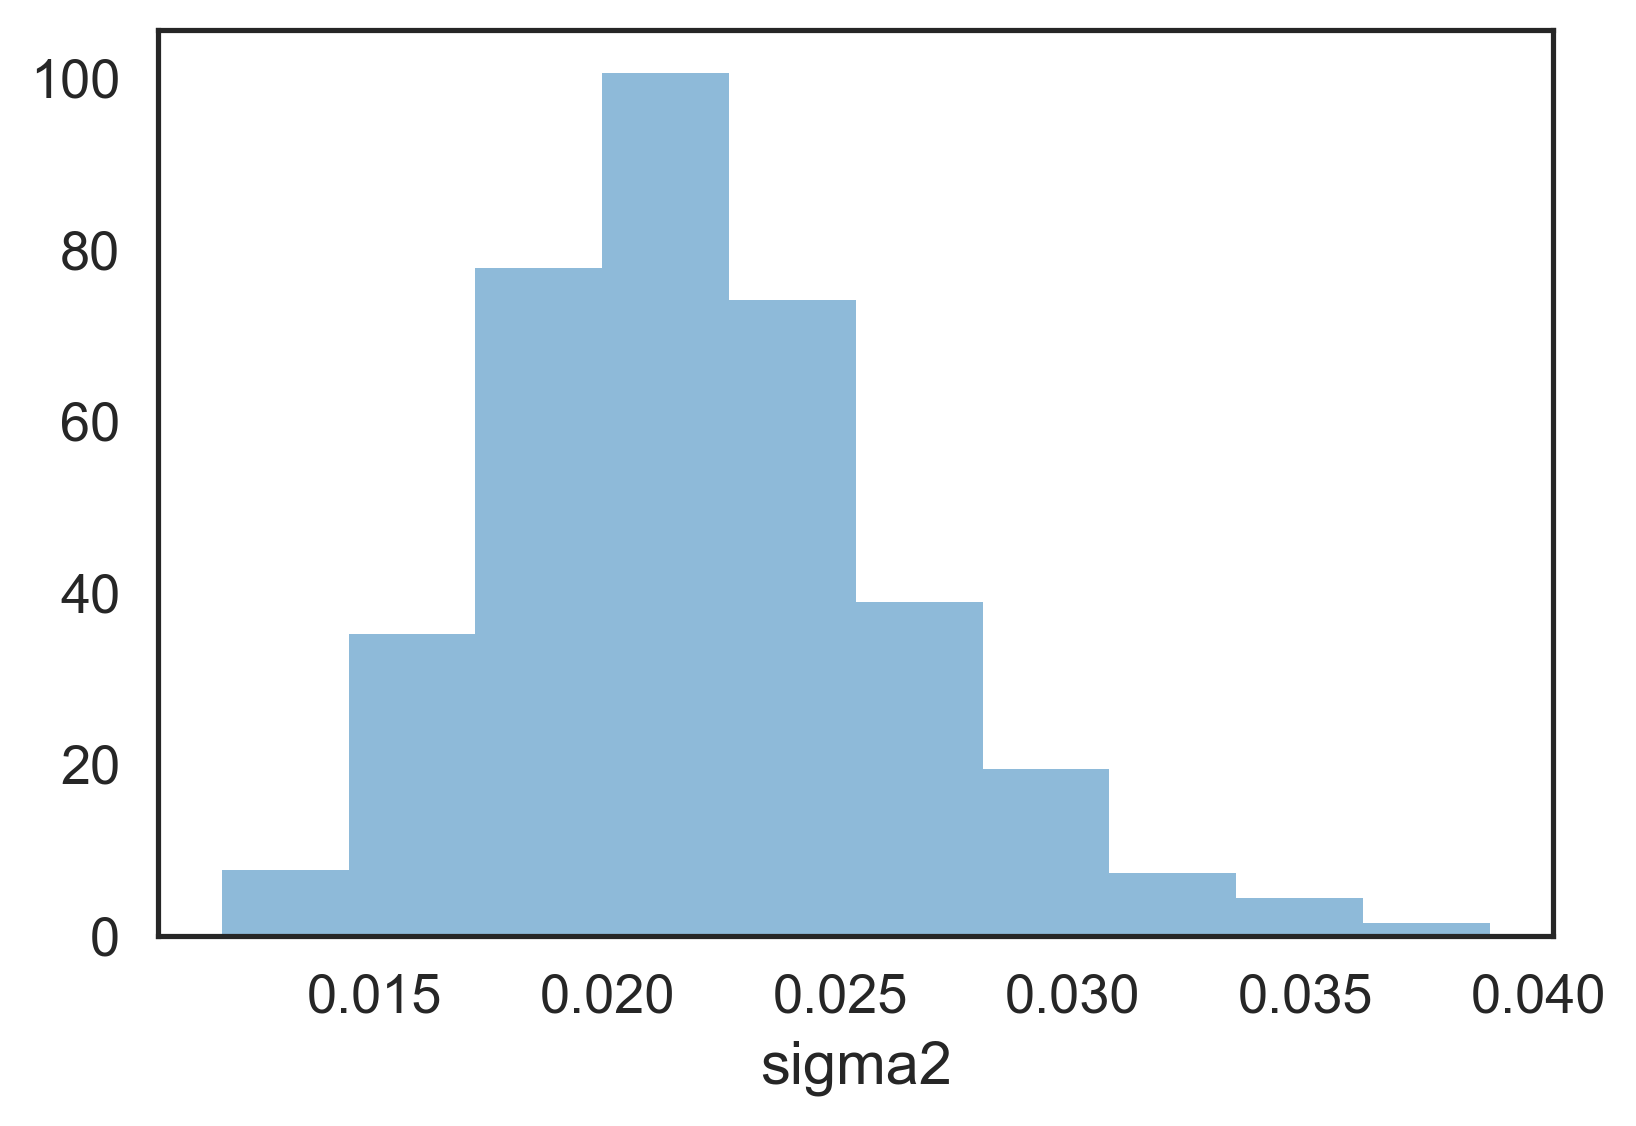

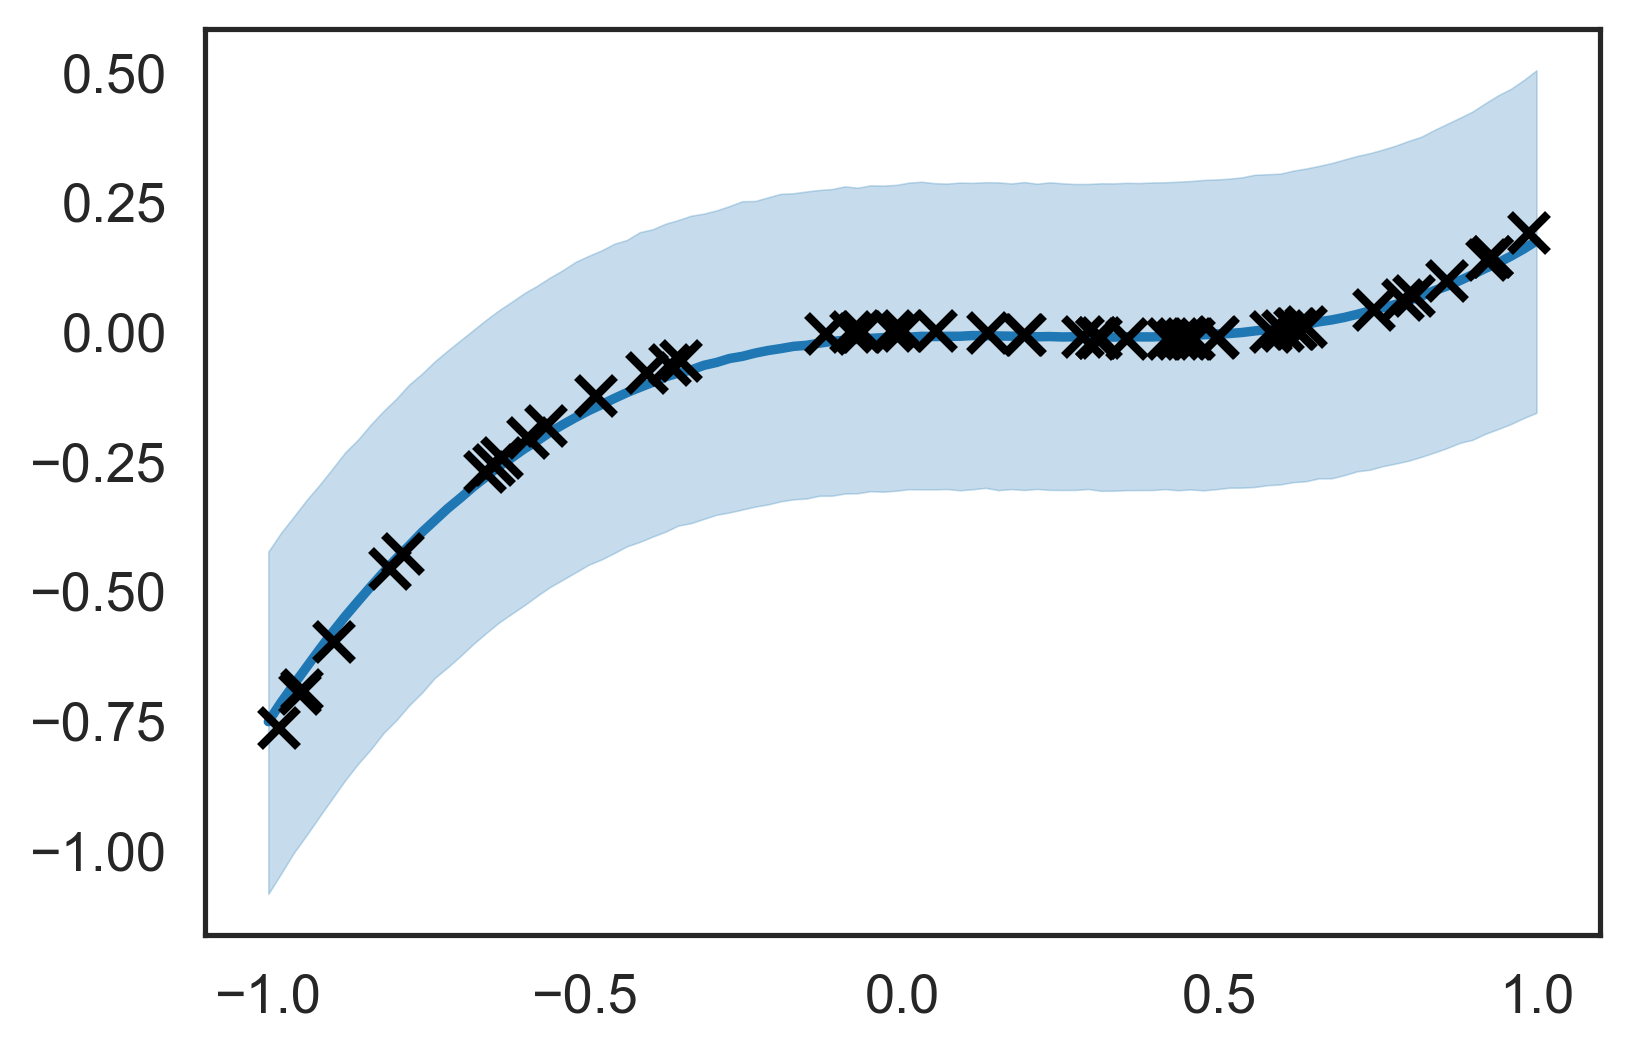

In [16]:
phi = PolynomialBasis(3)
advi = fit_poly_pm3(phi, X, y)
plot_posteriors_pm3(advi)
plot_predictive_pm3(phi, advi)

In [17]:
# Evaluate the ELBO for the various degrees
ELBOs = []
for d in [1, 2, 3, 4, 5]:
    phi = phi = PolynomialBasis(d)
    advi = fit_poly_pm3(phi, X, y)
    ELBO = -np.median(advi.hist[-1000:])
    print 'degree {0:1d} gives {1:1.3e}'.format(d, ELBO)
    ELBOs.append(ELBO)

Average Loss = -8.3303: 100%|██████████| 50000/50000 [00:53<00:00, 929.06it/s]
Finished [100%]: Average Loss = -8.3287


degree 1 gives 8.314e+00


Average Loss = -11.491: 100%|██████████| 50000/50000 [00:54<00:00, 919.72it/s] 
Finished [100%]: Average Loss = -11.49


degree 2 gives 1.152e+01


Average Loss = -15.421: 100%|██████████| 50000/50000 [00:54<00:00, 919.39it/s]
Finished [100%]: Average Loss = -15.425


degree 3 gives 1.540e+01


Average Loss = -14.027: 100%|██████████| 50000/50000 [00:55<00:00, 907.23it/s] 
Finished [100%]: Average Loss = -14.032


degree 4 gives 1.411e+01


Average Loss = -13.718: 100%|██████████| 50000/50000 [00:55<00:00, 904.15it/s] 
Finished [100%]: Average Loss = -13.704


degree 5 gives 1.389e+01


<BarContainer object of 5 artists>

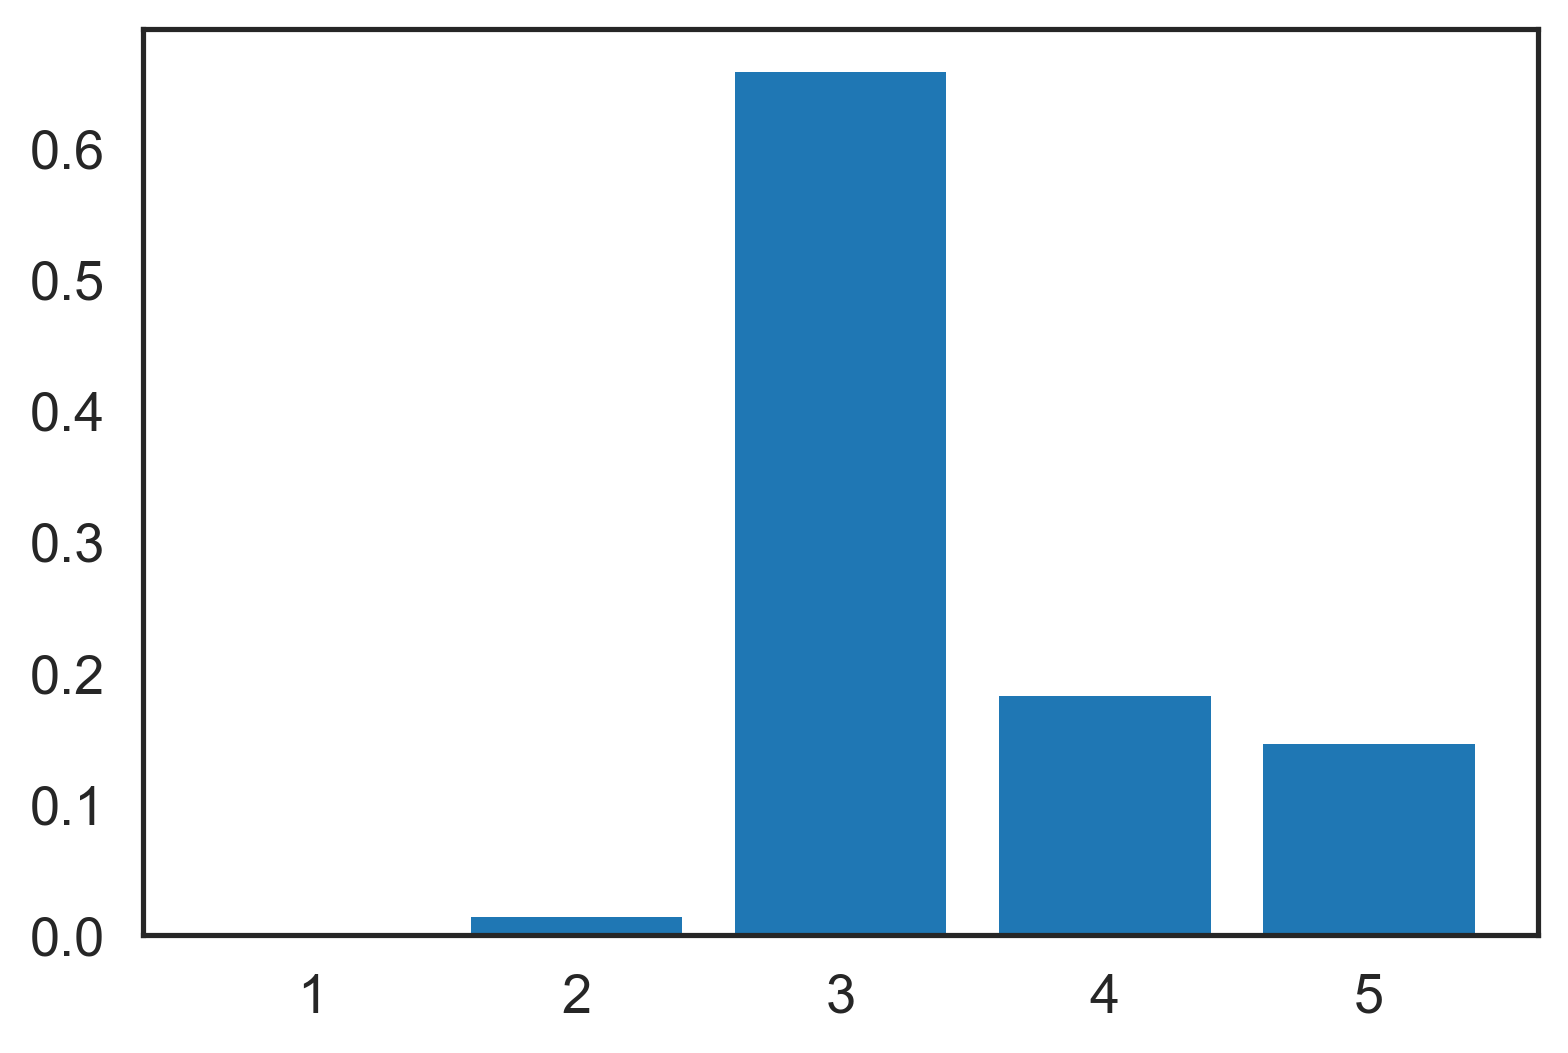

In [18]:
fig, ax = plt.subplots()
ax.bar(np.arange(1, len(ELBOs) + 1), np.exp(ELBOs) / np.sum(np.exp(ELBOs)))

# Revisiting Challenger Disaster Problem (Using PyMC3 Variational Inference)

Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


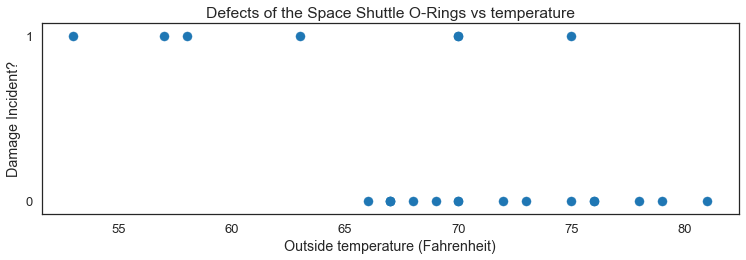

In [2]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
# drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# plot it, as a function of temperature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1])
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

## 1. Modeling with PyMC3 - ADVI

In [3]:
def make_model_pm3(challenger_data):
    model_pm3 = pm3.Model()

    # Load data
    temp = challenger_data[:, 0]
    temp_scaled = (temp - np.mean(temp))/np.std(temp) # to ensure proper mixing of MCMC chains
    D = challenger_data[:, 1]  # defect or not?

    with model_pm3:
        # Define Prior
        beta = pm3.Normal("beta", mu=0, tau=0.001) # 0 mean and small 0.001 precision - vague prior
        alpha = pm3.Normal("alpha", mu=0, tau=0.001)

        def p(t=temp_scaled, alpha=alpha, beta=beta):
            return 1.0 / (1. + np.exp(beta * t + alpha))

        observed = pm3.Bernoulli("bernoulli_obs",
                                 p(t = temp_scaled,
                                   alpha = alpha,
                                   beta = beta),
                                 observed = D)

        advi = pm3.ADVI()
    return advi

## 2 . Fit a variational distribution

In [4]:
advi = make_model_pm3(challenger_data)
advi.fit(n = 50000, obj_optimizer = pm3.adam())

Average Loss = 17.946: 100%|██████████| 50000/50000 [00:50<00:00, 982.19it/s]
Finished [100%]: Average Loss = 17.948


## 3. ADVI Convergence Diagnostics and Approximate Posterior Distributions

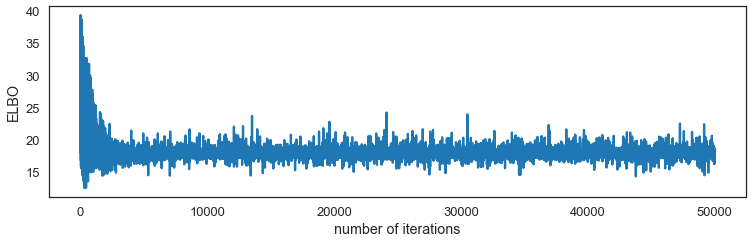

In [5]:
plt.plot(advi.hist)
plt.xlabel('number of iterations')
plt.ylabel('ELBO')
plt.show()

In [6]:
samples = advi.approx.sample(3000)
alpha_samples = samples['alpha']
beta_samples = samples['beta']

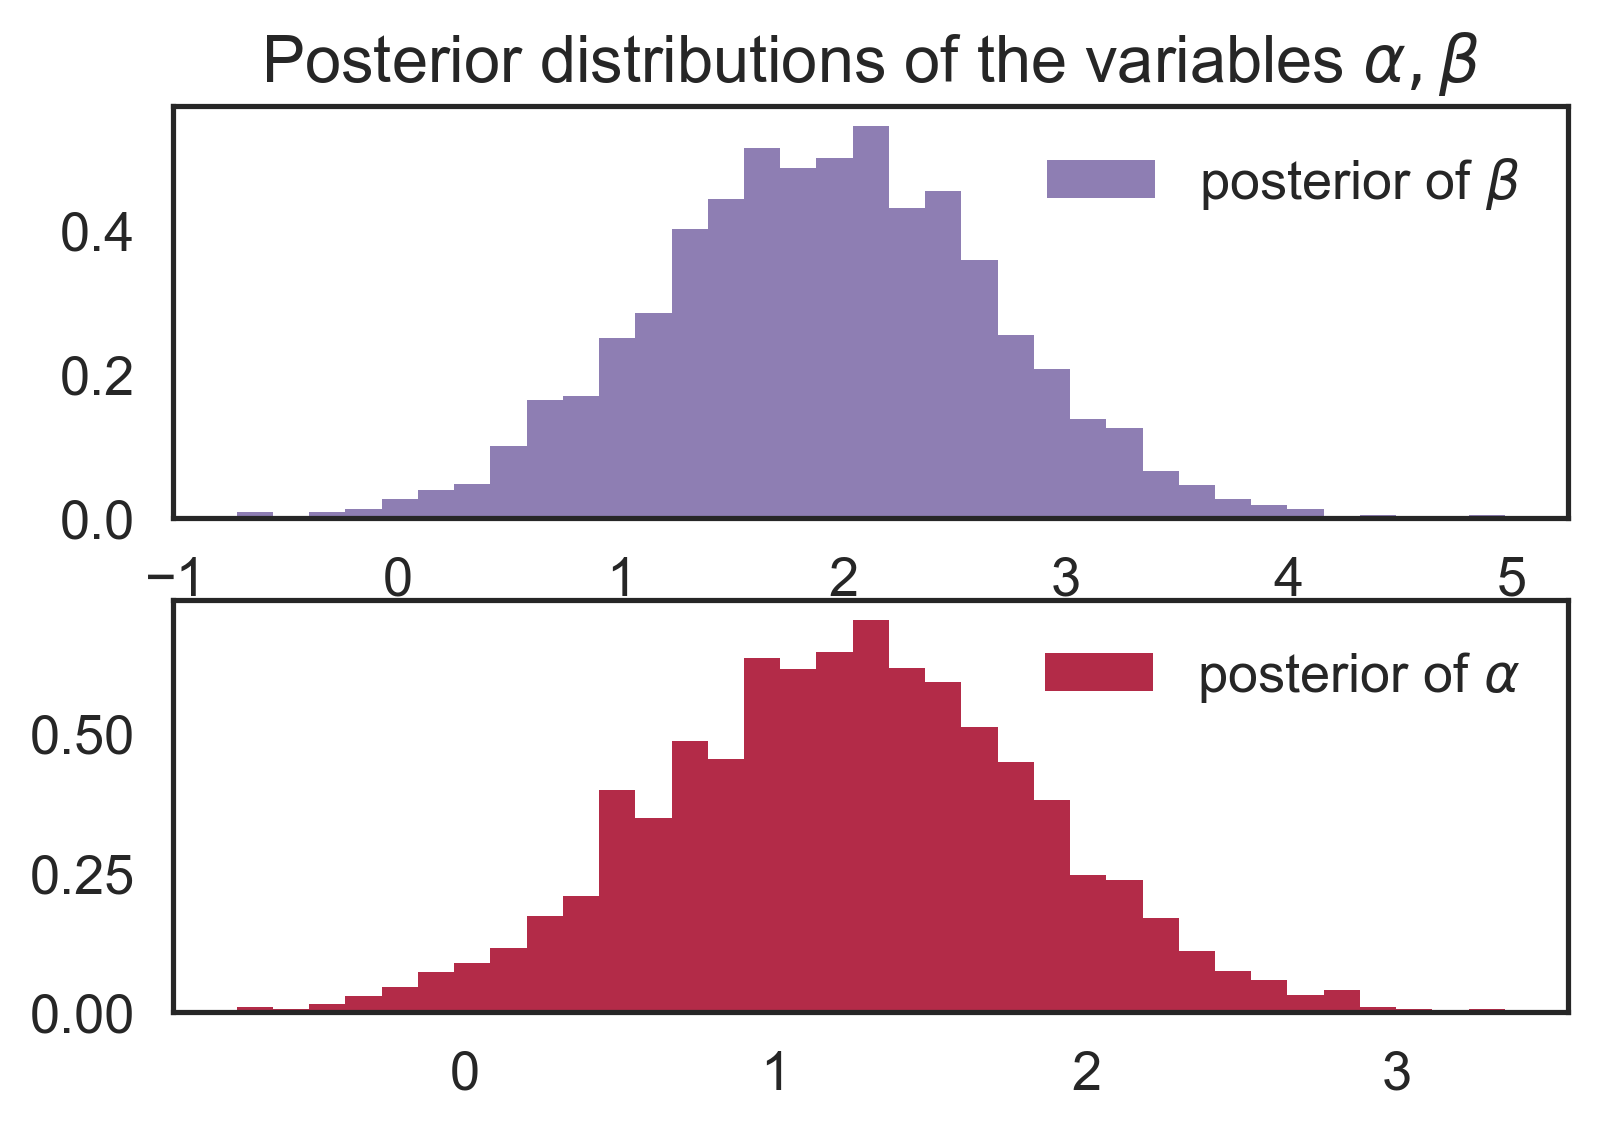

In [9]:
# histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

## 4. Approximate Posterior Predictive Distribution

In [10]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

temp = challenger_data[:, 0]
D = challenger_data[:, 1]

t = np.linspace(temp.min() - 5, temp.max() + 5, 50)[:, None]
t_scaled = (t - np.mean(temp))/np.std(temp)
p_t = logistic(t_scaled.T, beta_samples[:,None], alpha_samples[:,None])

mean_prob_t = p_t.mean(axis=0)

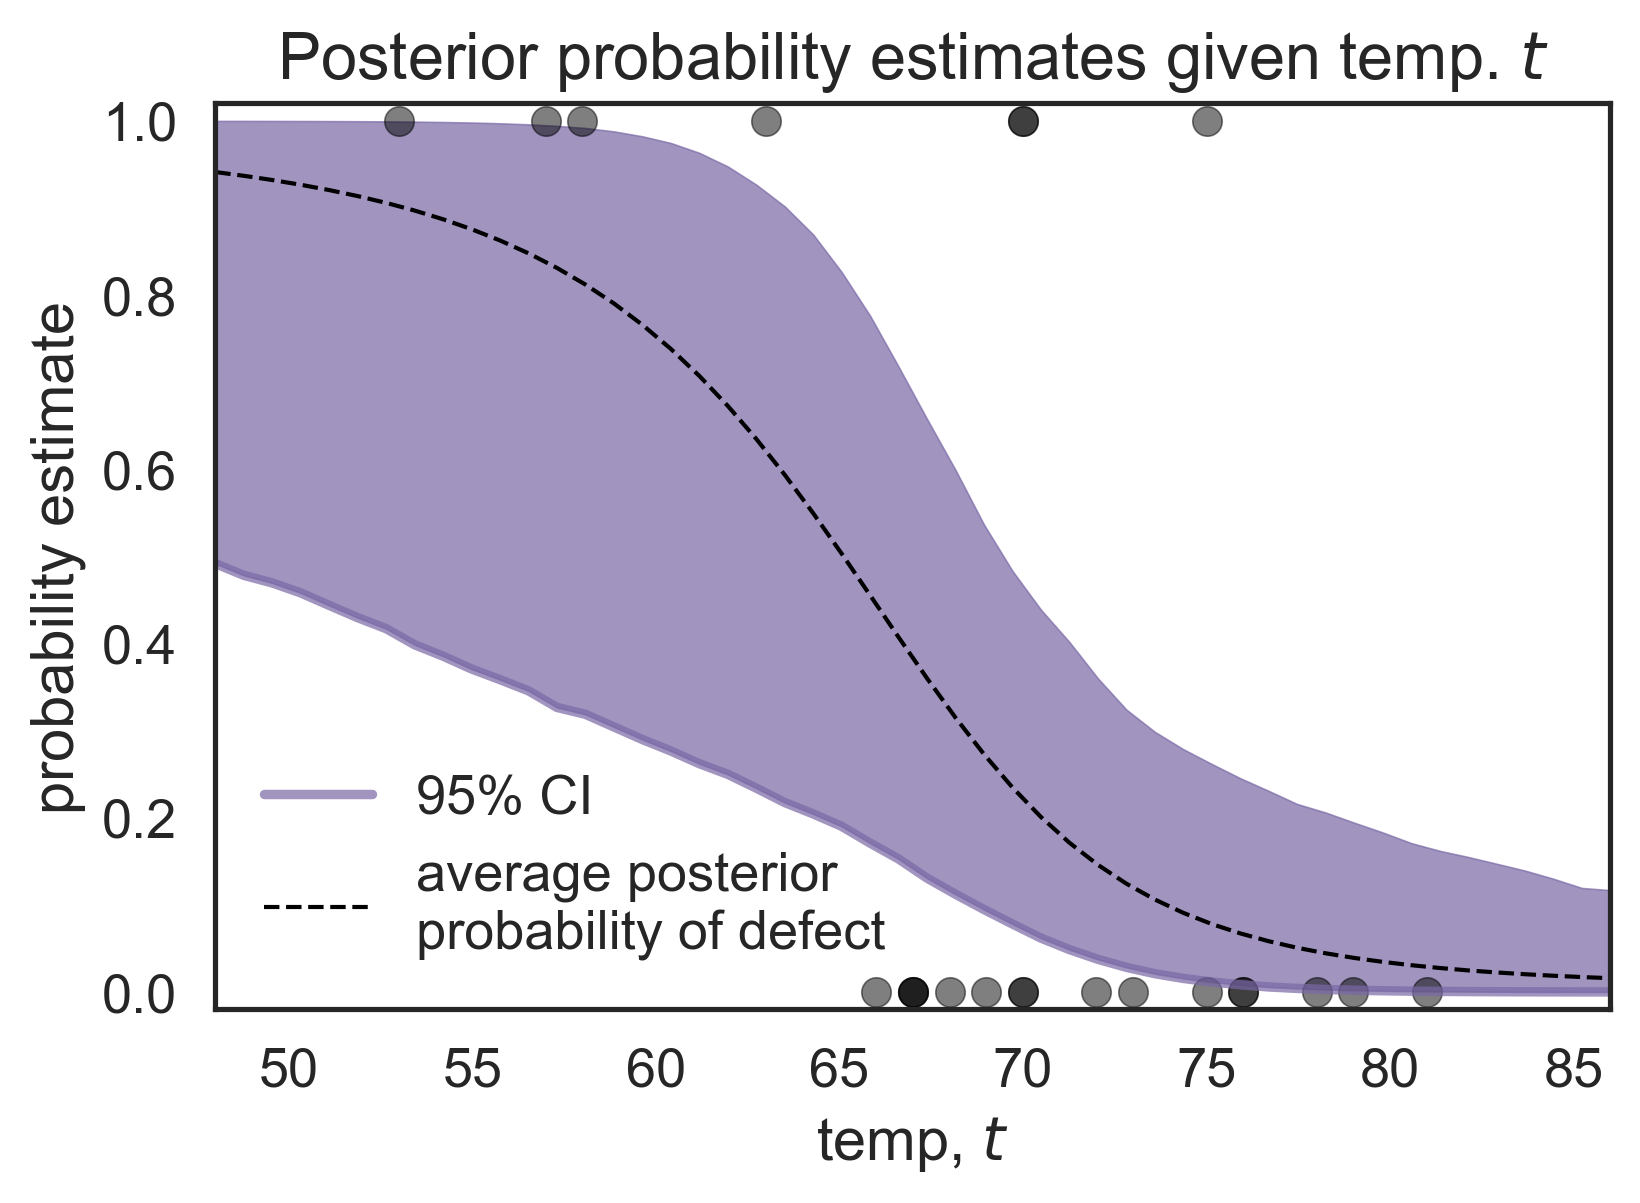

In [11]:
# vectorized bottom and top 2.5% quantiles for "confidence interval"
from scipy.stats.mstats import mquantiles
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temp, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

# Revisiting Motorcycle Problem (Using PyMC3 Variational Inference)

Text(0,0.5,'$y$')

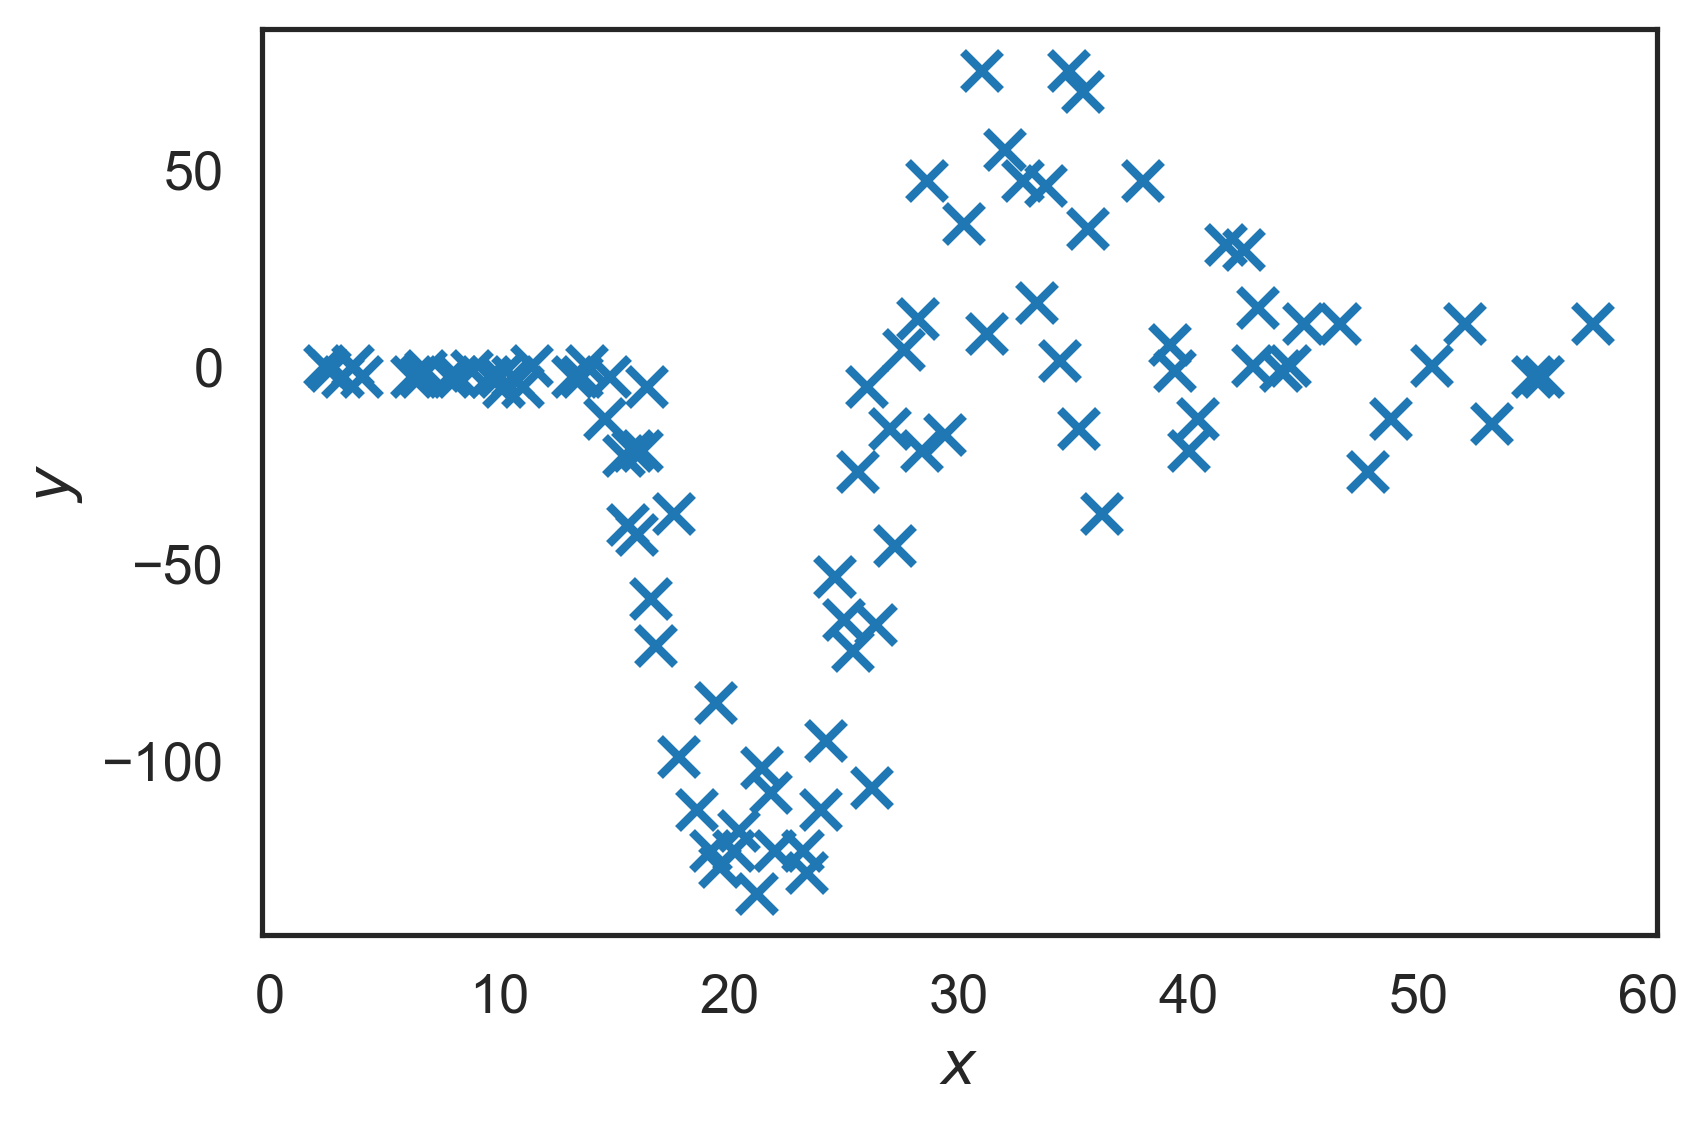

In [19]:
data = np.loadtxt('motor.dat')
X = data[:, 0][:, None]
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [20]:
def make_model_pm3(Phi, y):
    model = pm3.Model()
    with model:
        # The prior for sigmas
        sigma1 = pm3.Exponential('sigma1', 0.1)
        sigma2 = pm3.Exponential('sigma2', 0.1)
        
        # The prior of the weights
        w = pm3.Normal('w', mu = T.zeros(Phi.shape[1]), tau = 1./sigma1**2, shape = Phi.shape[1])
        # The likelihood
        y_obs = pm3.Normal('y_obs', mu = T.dot(Phi, w), tau = 1. / sigma2**2, observed = y)
      
        advi = pm3.ADVI()
    return advi

In [21]:
def fit_radial_pm3(ell, X, y):
    phi = RadialBasisFunctions(X, ell)
    Phi = compute_design_matrix(X, phi)
    advi = make_model_pm3(Phi, y)
    advi.fit(n = 50000, obj_optimizer = pm3.adam())
    return advi

def plot_posteriors_pm3(advi):
    samples = advi.approx.sample(1000)
    W = samples['w']
    fig, ax = plt.subplots()
    for j in xrange(W.shape[1]):
        ax.hist(W[:, j], normed=True, alpha=0.5, label='$w_{%d}$' % j)
    #plt.legend(loc='best')
    fig, ax = plt.subplots()
    sigma1 = samples['sigma1']
    ax.hist(sigma1, normed=True, label='$\sigma_1$', alpha=0.5)
    ax.set_xlabel('sigma1')
    fig, ax = plt.subplots()
    sigma2 = samples['sigma2']
    ax.hist(sigma2, normed=True, label='$\sigma_2$', alpha=0.5)
    ax.set_xlabel('sigma2')
    
def plot_predictive_pm3(phi, advi, num_samples=100):
    Xt = np.linspace(0, 60, 100)
    Phit = compute_design_matrix(Xt[:,None], phi)
    samples = advi.approx.sample(1000)
    W = samples['w']
    p_t = np.dot(W,Phit.T)
    mean_prob_t = np.mean(p_t, axis = 0)

    # vectorized bottom and top 2.5% quantiles for "confidence interval"
    qs = mquantiles(p_t, [0.025, 0.975], axis=0)
    plt.fill_between(Xt, *qs, alpha=0.7,
                     color="#7A68A6")

    plt.plot(Xt, qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

    plt.plot(Xt, mean_prob_t, lw=1, ls="--", color="k",
             label="average posterior \nprobability of defect")

    plt.xlim(Xt.min(), Xt.max())
    plt.legend(loc="best")
    plt.scatter(X, Y, color="k", s=50, alpha=0.5)

In [22]:
ell = 2.
advi = fit_radial_pm3(ell, X, Y)

Average Loss = 468: 100%|██████████| 50000/50000 [01:03<00:00, 785.54it/s]   
Finished [100%]: Average Loss = 467.97


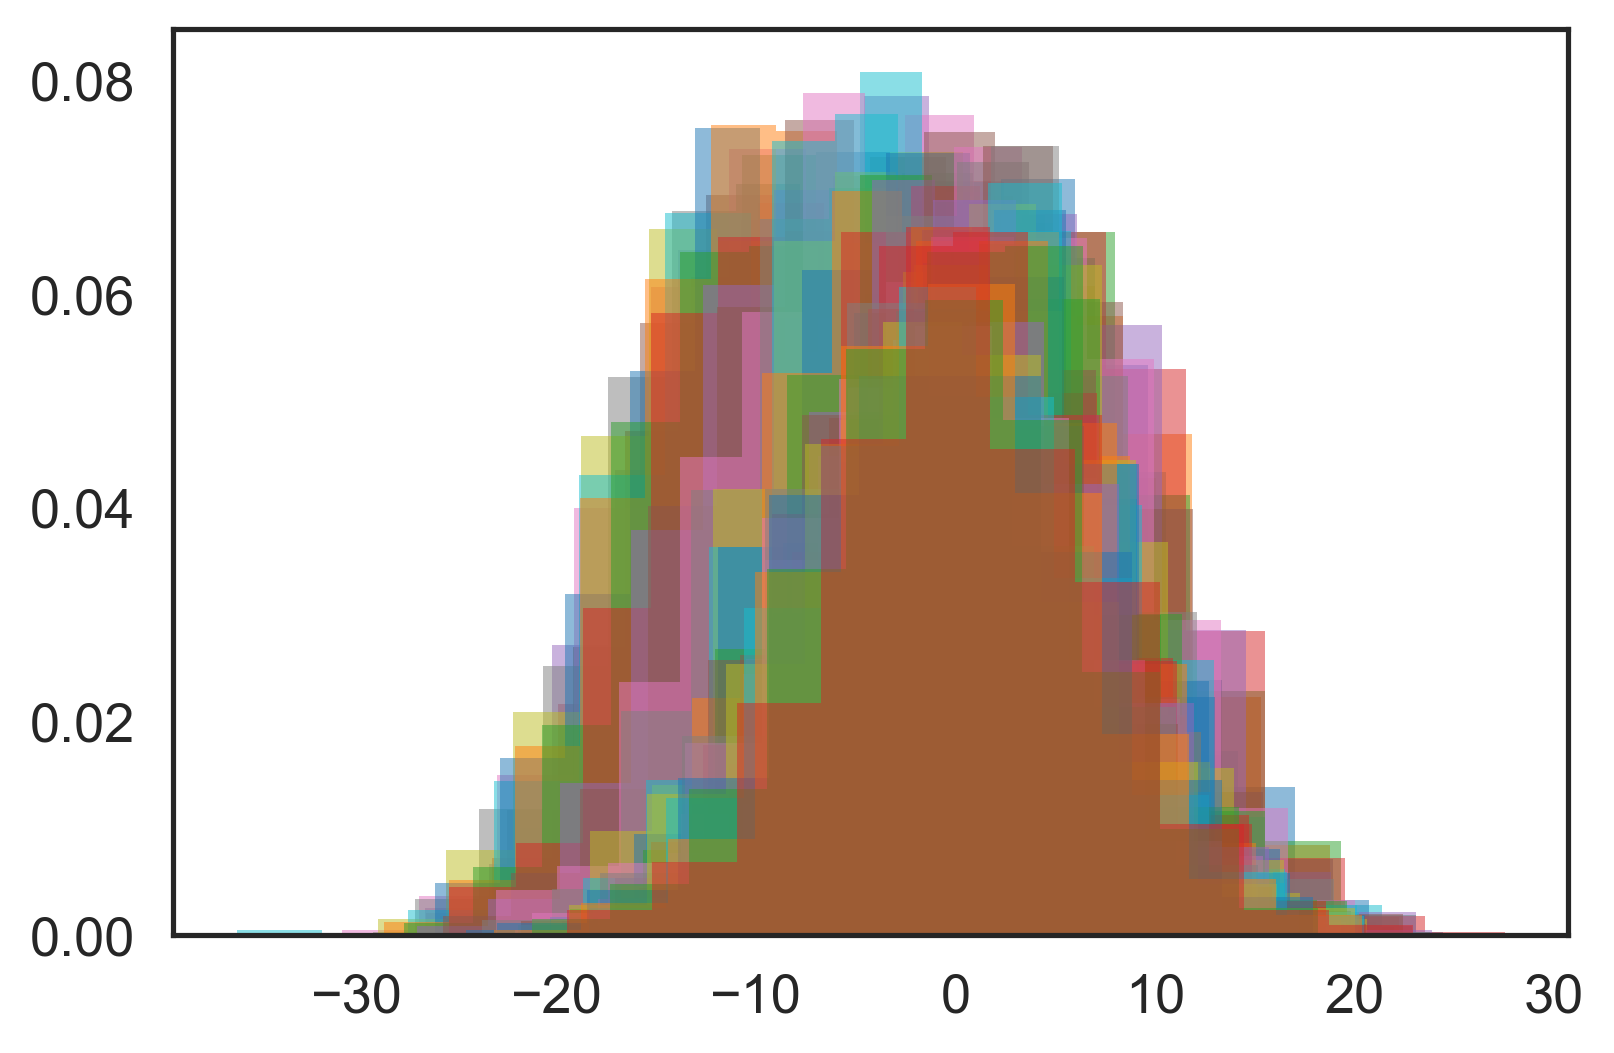

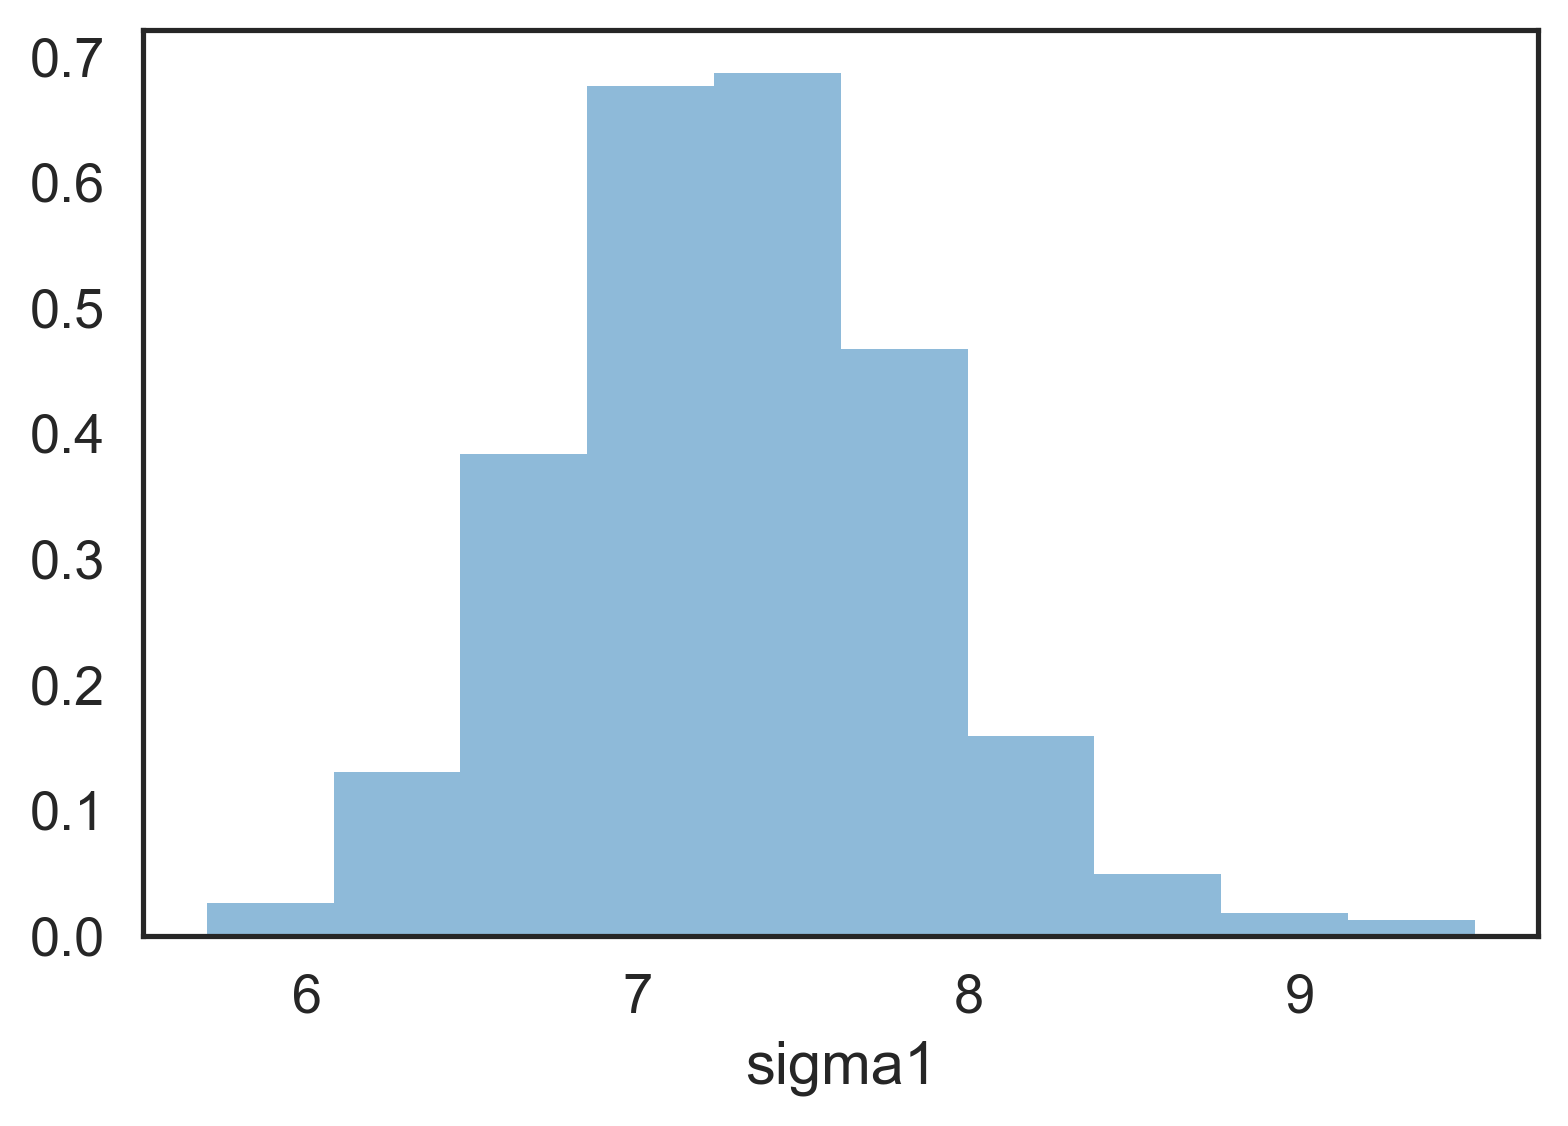

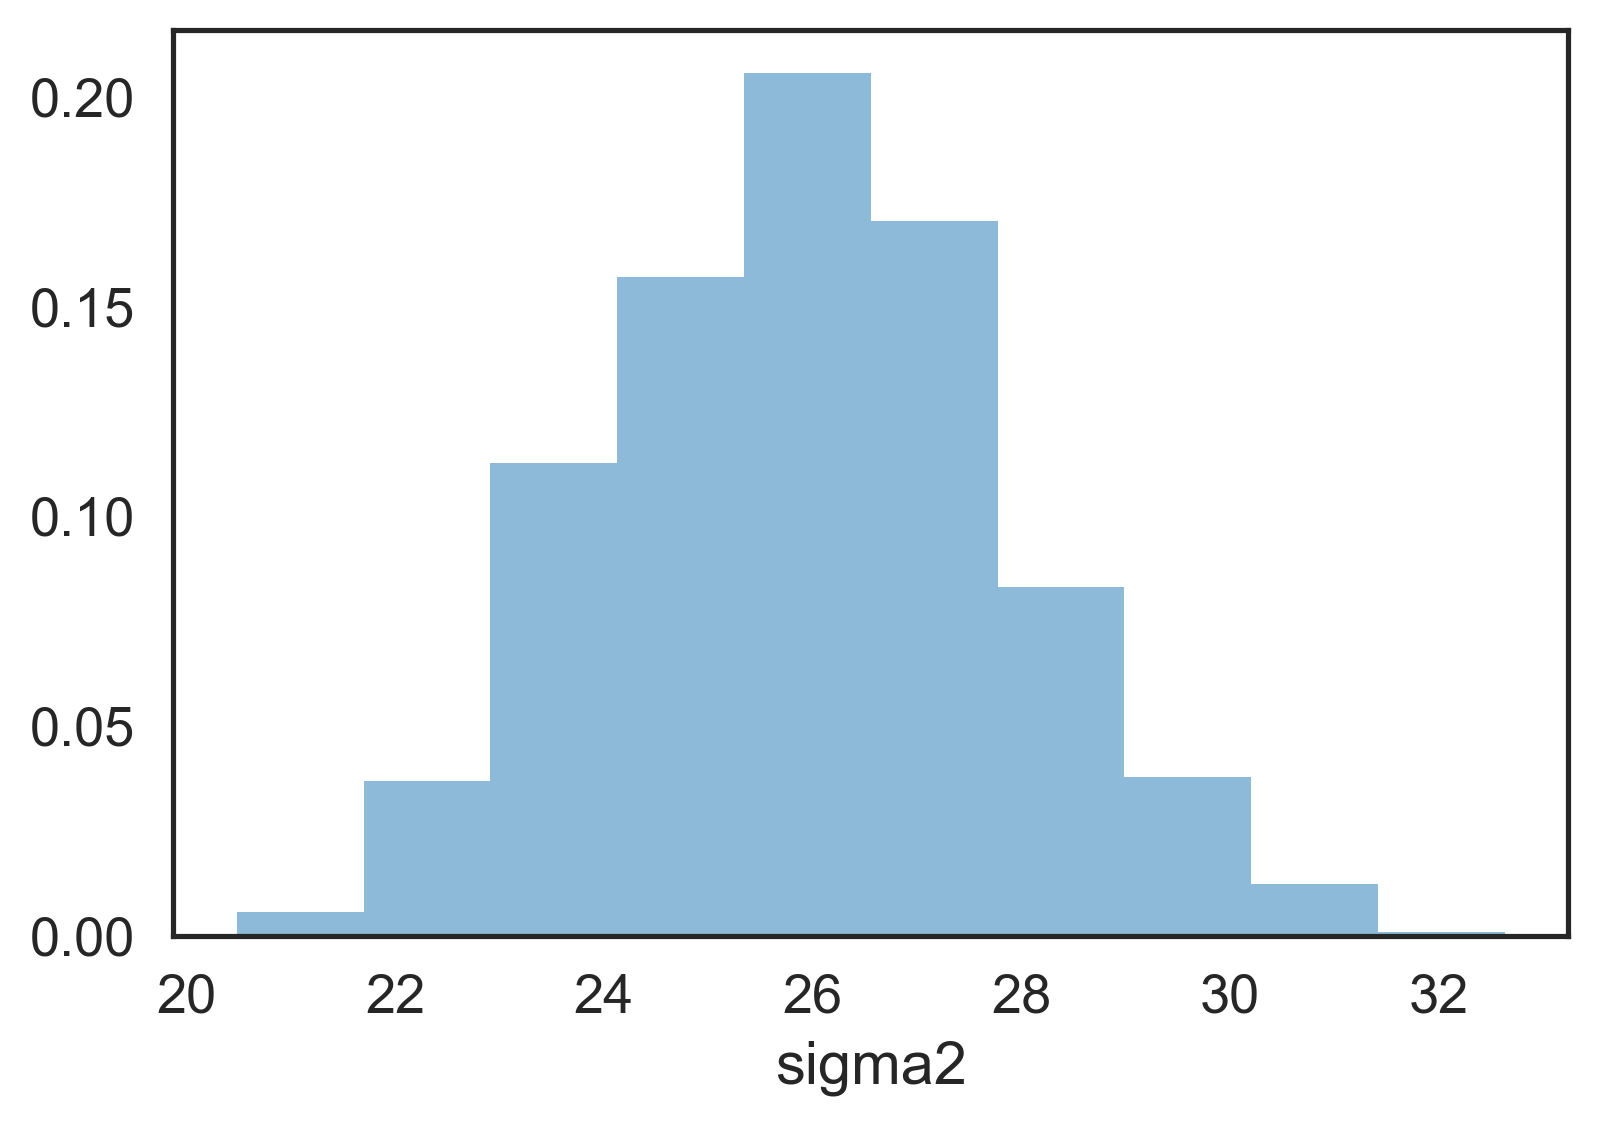

In [23]:
plot_posteriors_pm3(advi)

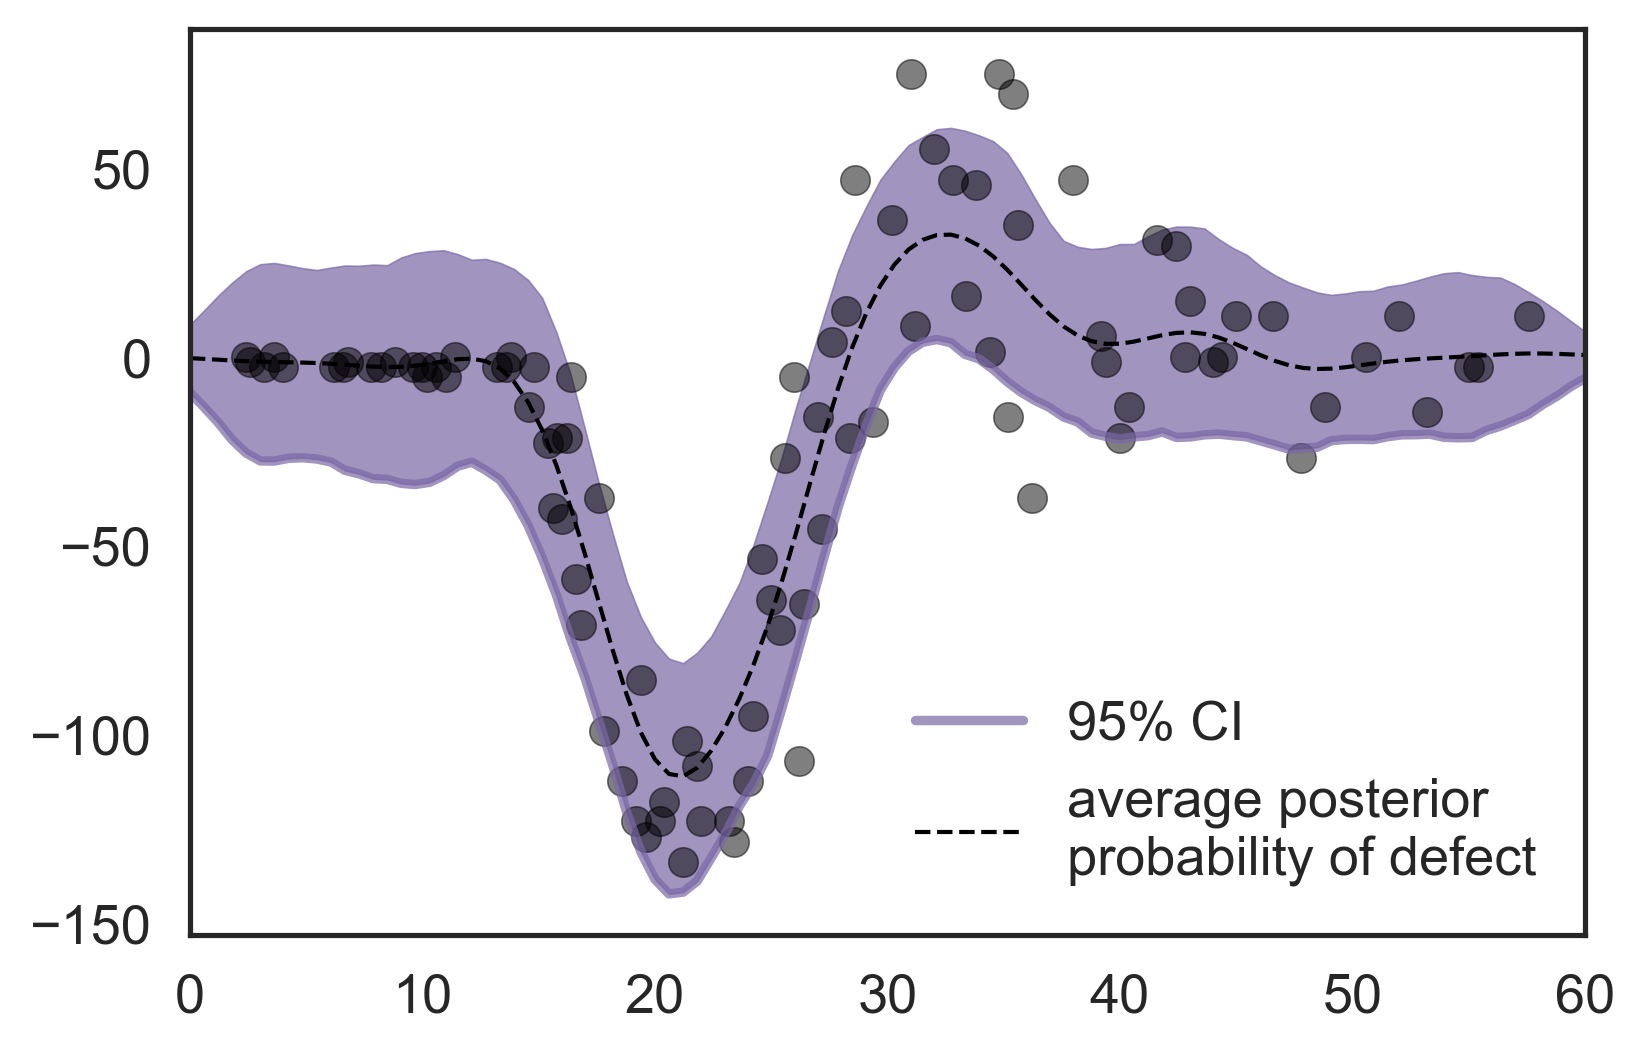

In [24]:
plt.figure()
phi = RadialBasisFunctions(X, ell)
plot_predictive_pm3(phi, advi)

In [25]:
# Evaluate the ELBO for the various lengthscales
ELBOs = []
for ell in [0.5, 2, 5, 10, 20]:
    advi = fit_radial_pm3(ell, X, Y)
    ELBO = -np.median(advi.hist[-1000:])
    print 'For ell = ' + str(ell) + ', EBLO is : ' + str(ELBO)
    ELBOs.append(ELBO)

Average Loss = 518.43: 100%|██████████| 50000/50000 [01:04<00:00, 772.96it/s]
Finished [100%]: Average Loss = 518.43


For ell = 0.5, EBLO is : -518.448899376


Average Loss = 468.09: 100%|██████████| 50000/50000 [01:03<00:00, 789.60it/s]
Finished [100%]: Average Loss = 468.12


For ell = 2, EBLO is : -466.96321795


Average Loss = 478.9: 100%|██████████| 50000/50000 [01:03<00:00, 791.47it/s] 
Finished [100%]: Average Loss = 478.86


For ell = 5, EBLO is : -476.602452876


Average Loss = 502.2: 100%|██████████| 50000/50000 [01:00<00:00, 829.73it/s] 
Finished [100%]: Average Loss = 502.18


For ell = 10, EBLO is : -500.526513662


Average Loss = 511.22: 100%|██████████| 50000/50000 [01:00<00:00, 828.98it/s]
Finished [100%]: Average Loss = 511.22


For ell = 20, EBLO is : -510.244706138


<BarContainer object of 5 artists>

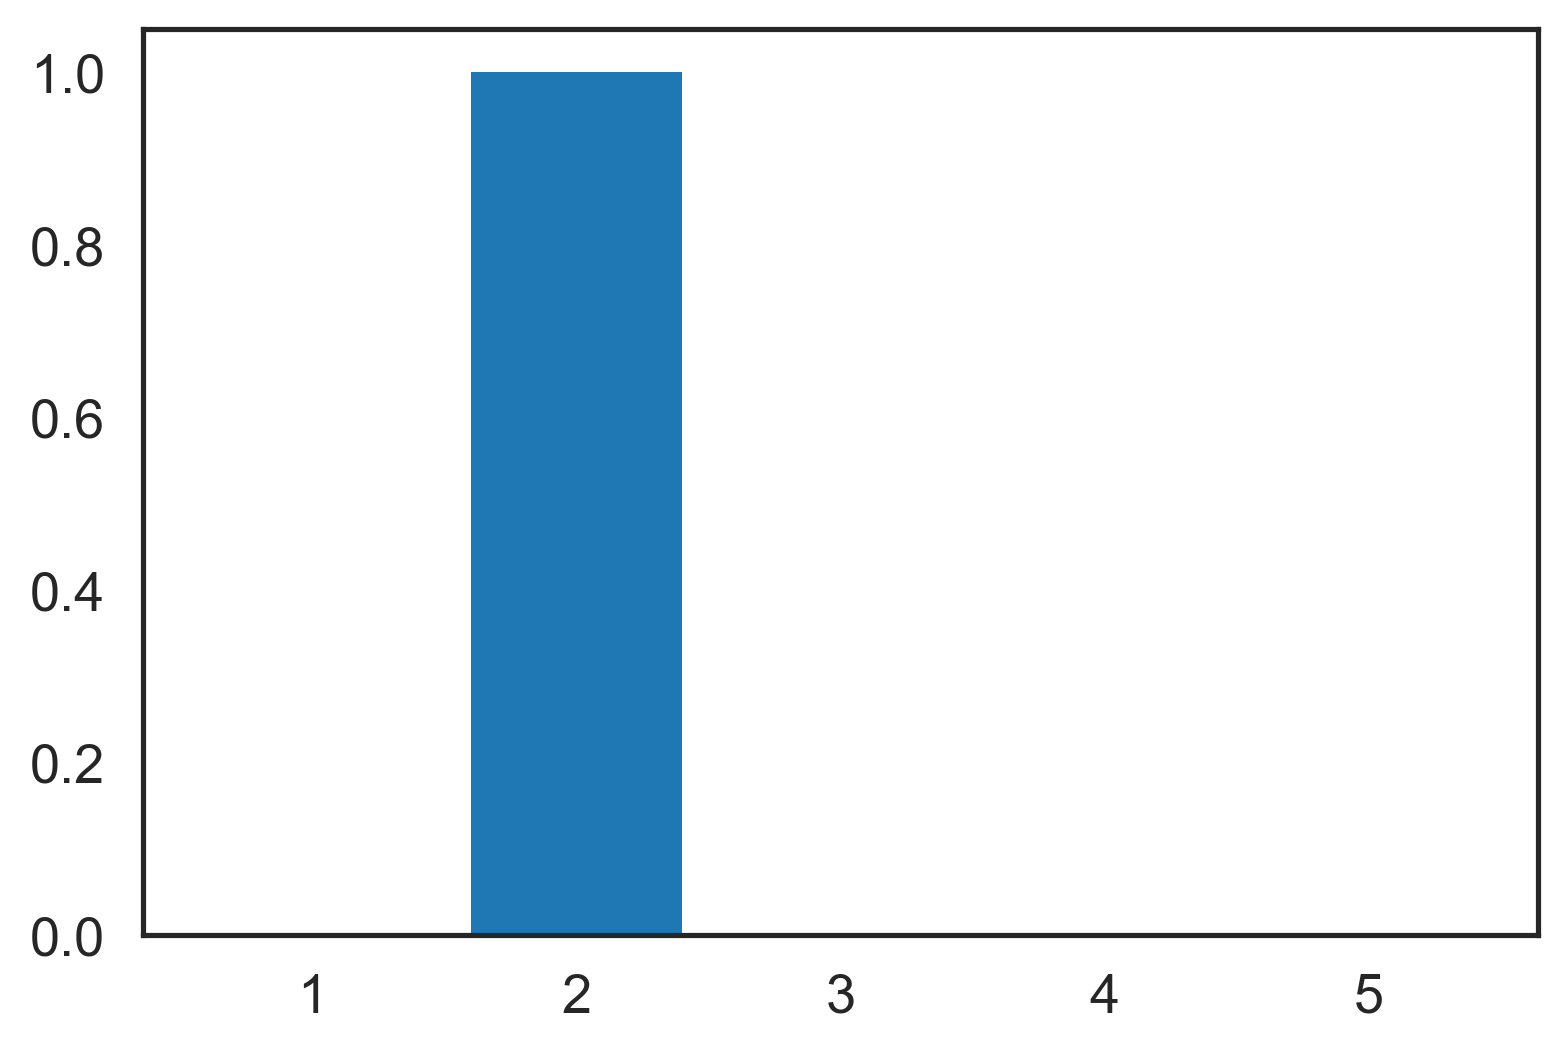

In [26]:
fig, ax = plt.subplots()
ax.bar(np.arange(1, len(ELBOs) + 1), np.exp(ELBOs) / np.sum(np.exp(ELBOs)))